## Аудио → мел-спектрограмма → преобразование в изображение 224×224 → классифицировать её с помощью Vision Transforme (ViT) → классификатор

используется Vision Transformer Base / 16 обученная на ImageNet

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio.transforms as T
from torchvision import transforms as TV
from torchvision.models import vit_b_16, ViT_B_16_Weights
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import soundfile as sf

device = torch.device("mps")
print("Device:", device)

DATA_ROOT = "speech_commands"
CLASSES = ['down', 'left', 'off', 'on', 'right', 'stop', 'up']
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 48
EPOCHS = 12
LR = 1e-4
WEIGHT_DECAY = 0.05

MEL_TRANSFORM = T.MelSpectrogram(
    sample_rate=16000,
    n_fft=1024,
    win_length=1024,
    hop_length=256,
    n_mels=128,
    f_min=0, f_max=8000
)

DB_TRANSFORM = T.AmplitudeToDB(top_db=80.0)

IMG_TRANSFORM = TV.Compose([
    TV.Resize((224, 224)),
    TV.Normalize(mean=[0.485, 0.456, 0.406],
                 std =[0.229, 0.224, 0.225]),
])

class SpeechCommands7(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        path, label = self.file_list[idx]

        wav_np, sr = sf.read(path, dtype="float32")
        wav = torch.from_numpy(wav_np)

        if wav.ndim == 1:
            wav = wav.unsqueeze(0)
        else:
            wav = wav.transpose(0, 1)

        if sr != 16000:
            wav = T.Resample(sr, 16000)(wav)

        if wav.shape[0] > 1:
            wav = wav.mean(0, keepdim=True)

        target_len = 16000
        if wav.shape[1] < target_len:
            wav = torch.nn.functional.pad(wav, (0, target_len - wav.shape[1]))
        else:
            wav = wav[:, :target_len]

        mel = MEL_TRANSFORM(wav)
        db = DB_TRANSFORM(mel)

        db = (db - db.min()) / (db.max() - db.min() + 1e-8)
        img = db.repeat(3, 1, 1)

        if self.transform is not None:
            img = self.transform(img)

        return img, label


file_list = []

for cls_idx, cls_name in enumerate(CLASSES):
    folder = Path(DATA_ROOT) / cls_name
    if not folder.is_dir():
        print(f"Папка не найдена: {folder}")
        continue
    for f in folder.glob("*.wav"):
        file_list.append((str(f), cls_idx))

print(f"Всего файлов найдено: {len(file_list)}")

train_size = int(0.85 * len(file_list))
val_size = len(file_list) - train_size

train_files, val_files = torch.utils.data.random_split(
    file_list, [train_size, val_size], generator=torch.Generator().manual_seed(42)
)

train_ds = SpeechCommands7(train_files, transform=IMG_TRANSFORM)
val_ds   = SpeechCommands7(val_files,   transform=IMG_TRANSFORM)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}")

/opt/miniconda3/envs/Lesson_44/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: mps
Всего файлов найдено: 16471
Train: 14000, Val: 2471


In [2]:
# Модель
weights = ViT_B_16_Weights.DEFAULT
model = vit_b_16(weights=weights)

for param in model.parameters():
    param.requires_grad = False

for name, param in model.named_parameters():
    if "heads" in name or "encoder.layers.encoder_layer_11" in name or "encoder.layers.encoder_layer_10" in name:
        param.requires_grad = True

model.heads.head = nn.Linear(model.heads.head.in_features, NUM_CLASSES)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS*2, eta_min=1e-6)

In [3]:
# Цикл обучения
best_acc = 0.0
best_epoch = 0

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.
    correct = 0
    total = 0

    for x, y in tqdm(train_loader, desc=f"Ep {epoch+1}/{EPOCHS}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, pred = out.max(1)
        correct += pred.eq(y).sum().item()
        total += y.size(0)

    train_loss /= len(train_loader)
    train_acc = correct / total

    model.eval()
    val_loss = 0.
    correct = 0
    total = 0
    preds_all, trues_all = [], []

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)

            val_loss += loss.item()
            _, pred = out.max(1)
            correct += pred.eq(y).sum().item()
            total += y.size(0)

            preds_all.extend(pred.cpu().numpy())
            trues_all.extend(y.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = correct / total

    print(f"[{epoch+1:2d}/{EPOCHS}]  train loss: {train_loss:.4f}  acc: {train_acc:.4f}   |   "
          f"val loss: {val_loss:.4f}  acc: {val_acc:.4f}   lr={optimizer.param_groups[0]['lr']:.2e}")

    scheduler.step()

    if val_acc > best_acc:
        best_acc = val_acc
        best_epoch = epoch + 1
        torch.save(model.state_dict(), "best_vit_speech.pt")
        print(f"→ новая лучшая модель, сохранена (acc = {val_acc:.4f})")

print(f"\nЛучшая валидационная точность: {best_acc:.4f} на эпохе {best_epoch}")

Ep 1/12:   0%|          | 0/292 [00:00<?, ?it/s]/opt/miniconda3/envs/Lesson_44/lib/python3.10/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)
Error processing line 1 of /opt/miniconda3/envs/Lesson_44/lib/python3.10/site-packages/distutils-precedence.pth:

  Traceback (most recent call last):
    File "/opt/miniconda3/envs/Lesson_44/lib/python3.10/site.py", line 195, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
  ModuleNotFoundError: No module named '_distutils_hack'

Remainder of file ignored
Ep 1/12: 100%|██████████| 292/292 [12:57<00:00,  2.66s/it]


[ 1/12]  train loss: 0.7967  acc: 0.7003   |   val loss: 0.5208  acc: 0.8134   lr=1.00e-04
→ новая лучшая модель, сохранена (acc = 0.8134)


Ep 2/12: 100%|██████████| 292/292 [19:12<00:00,  3.95s/it]  


[ 2/12]  train loss: 0.3919  acc: 0.8624   |   val loss: 0.4053  acc: 0.8584   lr=9.96e-05
→ новая лучшая модель, сохранена (acc = 0.8584)


Ep 3/12: 100%|██████████| 292/292 [13:17<00:00,  2.73s/it]


[ 3/12]  train loss: 0.2609  acc: 0.9057   |   val loss: 0.3411  acc: 0.8863   lr=9.83e-05
→ новая лучшая модель, сохранена (acc = 0.8863)


Ep 4/12: 100%|██████████| 292/292 [13:29<00:00,  2.77s/it]


[ 4/12]  train loss: 0.1756  acc: 0.9381   |   val loss: 0.3429  acc: 0.8875   lr=9.62e-05
→ новая лучшая модель, сохранена (acc = 0.8875)


Ep 5/12: 100%|██████████| 292/292 [13:58<00:00,  2.87s/it]


[ 5/12]  train loss: 0.1043  acc: 0.9650   |   val loss: 0.3271  acc: 0.9008   lr=9.34e-05
→ новая лучшая модель, сохранена (acc = 0.9008)


Ep 6/12: 100%|██████████| 292/292 [14:44<00:00,  3.03s/it]


[ 6/12]  train loss: 0.0715  acc: 0.9746   |   val loss: 0.3633  acc: 0.8944   lr=8.98e-05


Ep 7/12: 100%|██████████| 292/292 [38:10<00:00,  7.84s/it]    


[ 7/12]  train loss: 0.0472  acc: 0.9835   |   val loss: 0.3507  acc: 0.9122   lr=8.55e-05
→ новая лучшая модель, сохранена (acc = 0.9122)


Ep 8/12: 100%|██████████| 292/292 [15:04<00:00,  3.10s/it]


[ 8/12]  train loss: 0.0350  acc: 0.9887   |   val loss: 0.3757  acc: 0.9049   lr=8.06e-05


Ep 9/12: 100%|██████████| 292/292 [13:44<00:00,  2.82s/it]


[ 9/12]  train loss: 0.0300  acc: 0.9902   |   val loss: 0.3743  acc: 0.9077   lr=7.53e-05


Ep 10/12: 100%|██████████| 292/292 [13:05<00:00,  2.69s/it]


[10/12]  train loss: 0.0196  acc: 0.9939   |   val loss: 0.4058  acc: 0.9085   lr=6.94e-05


Ep 11/12: 100%|██████████| 292/292 [13:43<00:00,  2.82s/it]


[11/12]  train loss: 0.0144  acc: 0.9961   |   val loss: 0.4183  acc: 0.9021   lr=6.33e-05


Ep 12/12: 100%|██████████| 292/292 [14:33<00:00,  2.99s/it]


[12/12]  train loss: 0.0090  acc: 0.9973   |   val loss: 0.3970  acc: 0.9114   lr=5.70e-05

Лучшая валидационная точность: 0.9122 на эпохе 7


Inference: 100%|██████████| 52/52 [01:39<00:00,  1.92s/it]


              precision    recall  f1-score   support

        down     0.9315    0.9315    0.9315       365
        left     0.9542    0.9148    0.9341       364
         off     0.8509    0.8765    0.8635       332
          on     0.8841    0.8986    0.8913       365
       right     0.9446    0.9394    0.9420       363
        stop     0.9283    0.9430    0.9356       316
          up     0.8923    0.8825    0.8874       366

    accuracy                         0.9122      2471
   macro avg     0.9123    0.9123    0.9122      2471
weighted avg     0.9127    0.9122    0.9123      2471



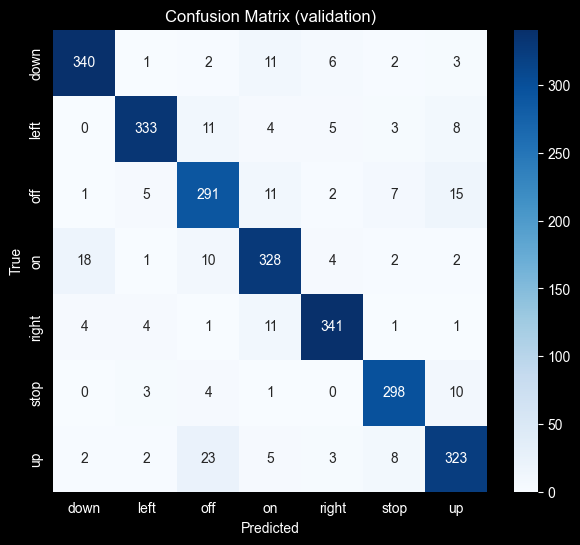

In [4]:
model.load_state_dict(torch.load("best_vit_speech.pt"))
model.eval()

all_preds = []
all_trues = []

with torch.no_grad():
    for x, y in tqdm(val_loader, desc="Inference"):
        x = x.to(device)
        out = model(x)
        pred = out.argmax(dim=1).cpu().numpy()
        all_preds.extend(pred)
        all_trues.extend(y.numpy())

print(classification_report(all_trues, all_preds, target_names=CLASSES, digits=4))


cm = confusion_matrix(all_trues, all_preds)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (validation)')
plt.show()